In [1]:
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path

In [2]:
OUTPUT_DIR = Path("figures")

#### 1. Create Ring Attractor Modules

In [3]:
N_MODULES = 4
N_NEURONS = 360
BASE_FREQ = 20.0              # Continuous attractor bump width parameter
LM_POS = (180,)  # Landmark locations
NUM_STEPS = 1_000_000
NUM_TRAINING_STEPS = 500_000
LOG_EVERY = 2_000
LM_MODULE = 2                 # Which continuous attractor module is tuned to landmark position
LR = 1e-7

In [4]:
def create_bump(width: int, sigma: float, amp: float = 1.0) -> np.ndarray:
    z = np.arange(-width/2, width/2)
    bump_vec = np.exp(-(z**2) / (2 * sigma**2))
    bump_vec /= bump_vec.max()
    bump_vec *= amp
    return bump_vec

In [6]:
def init_module(width: int, sigma: float, amp: float = 1.0) -> np.ndarray:
    # Create the bump vector
    bump_vec = create_bump(width, sigma, amp)
    # Convert the bump vector into a toeplitz matrix
    toeplitz = np.empty((width, width))
    for col in range(width):
        toeplitz[:, col] = np.roll(bump_vec, col)
    return toeplitz

In [7]:
scales = []
modules = []
for i in range(N_MODULES):
    scale = 1.1 ** (i + 1 - N_MODULES / 2)
    scales.append(scale)
    modules.append(init_module(N_NEURONS, scale * BASE_FREQ, amp=1.0))
scales = np.array(scales)

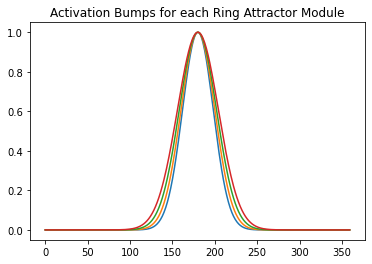

In [8]:
plt.title('Activation Bumps for each Ring Attractor Module')
plt.plot(np.arange(N_NEURONS), modules[0][:, 0])
plt.plot(np.arange(N_NEURONS), modules[1][:, 0])
plt.plot(np.arange(N_NEURONS), modules[2][:, 0])
plt.plot(np.arange(N_NEURONS), modules[3][:, 0])
plt.show()

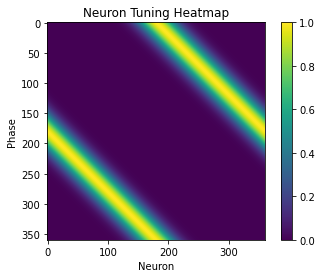

In [9]:
plt.title("Neuron Tuning Heatmap")
plt.imshow(modules[LM_MODULE], cmap="viridis")
plt.colorbar()
plt.xlabel("Neuron")
plt.ylabel("Phase")
plt.show()

#### 2. Create the External Landmark Stimulus

In [10]:
lm_idxs = (np.asarray(LM_POS, dtype=float) / 360.0 * N_NEURONS).astype(int) # Map LM positions to neuron idxs
bump = create_bump(N_NEURONS, BASE_FREQ, amp=1.0)
ext_lm_stimuli = np.zeros(bump.shape)
for offset in lm_idxs:
    ext_lm_stimuli += np.roll(bump, offset)

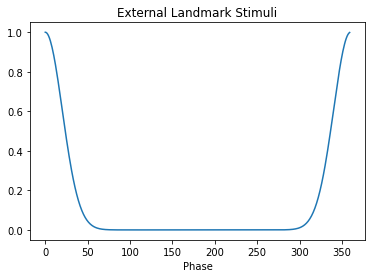

In [11]:
plt.plot(np.arange(N_NEURONS), ext_lm_stimuli)
plt.xlabel("Phase")
plt.title("External Landmark Stimuli")
plt.show()

#### 3. Initialize the Synaptic Weights

In [12]:
tot_neurons = N_MODULES * N_NEURONS
weights = np.random.randn(N_NEURONS, N_MODULES) / tot_neurons

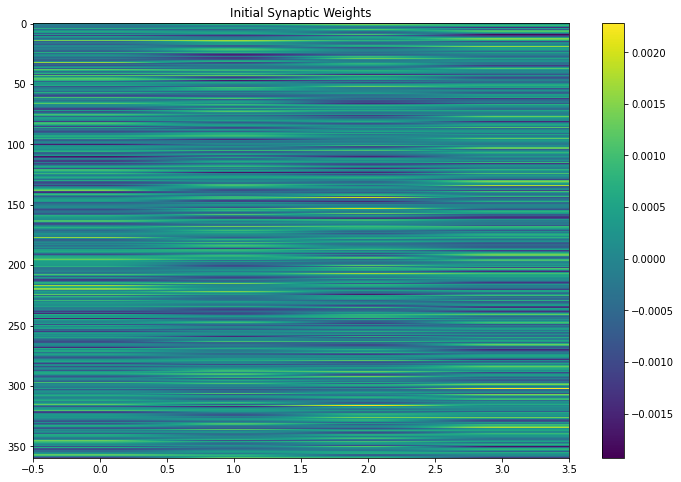

In [13]:
plt.figure(figsize=(12, 8))
plt.title("Initial Synaptic Weights")
plt.imshow(weights, aspect="auto", cmap="viridis")
plt.colorbar()
plt.show()

#### 4. Landmark Position Learning

In [14]:
is_testing = [] # Track whether we're training or testing
weight_snapshots = [] # Copies of weights during training/testing

for t in range(1, NUM_STEPS + 1):
    #
    # External Position Representation
    #
    #    Note 1: We assume the position is moving with constant speed so
    #            we can use time and position interchangably
    #
    #    Note 2: Each module has its own time scale
    #
    pos = np.round(t / scales).astype(int)
    #
    # Ring Attractor Phases
    #
    phases = (pos - 1) % N_NEURONS
    #
    # Ring Attractor Neuron Activations
    #
    module_activations = np.empty((N_NEURONS, N_MODULES))
    for module_idx, module in enumerate(modules):
        module_activations[:, module_idx] = module[:, phases[module_idx]]
    #
    # Landmark Neuron Internal Input
    #
    #    Note: This is the input the landmark neuron recieves from the ring attractors
    #
    lm_int = float(np.sum(weights * module_activations))
    #
    # Landmark Neuron External Input
    #
    #    Note: This is the input the landmark neuron recieves from viewing the landmark
    #
    ext_phase = phases[LM_MODULE]
    lm_ext = ext_lm_stimuli[ext_phase]
    #
    # Landmark Neuron Total Input
    #
    #     Note: The LM neuron only recieves external stimuli during training
    #
    lm_input = lm_int + (lm_ext if t < NUM_TRAINING_STEPS else 0)
    #
    # Synaptic Weights Learning Update
    #
    weights += LR * lm_input * (module_activations - lm_input * weights)
    weights -= weights.mean(axis=0, keepdims=True)
    #
    # Log
    #
    if (t % LOG_EVERY) == 0:
        is_testing.append(t > NUM_TRAINING_STEPS)
        weight_snapshots.append(weights.copy())

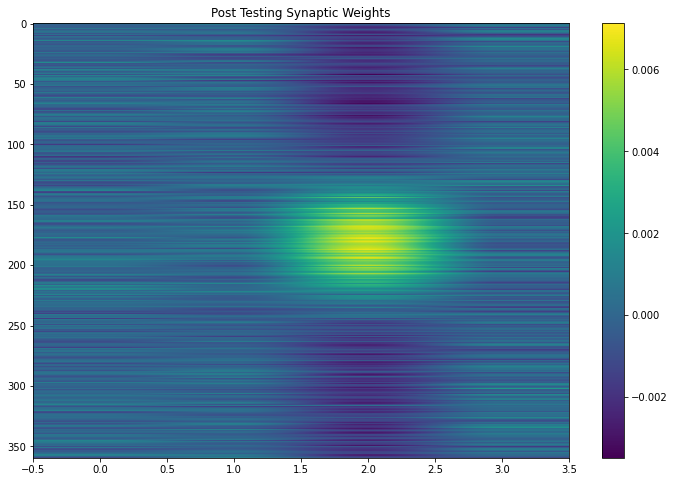

In [15]:
plt.figure(figsize=(12, 8))
plt.title("Post Testing Synaptic Weights")
plt.imshow(weights, aspect="auto", cmap="viridis")
plt.colorbar()
plt.show()

#### 5. Plot Weight Snapshots

In [3]:
# Configure which snapshots we want to plot
num_snaps = len(weight_snapshots)
early_idx = 0
mid_idx = num_snaps // 2
post_training_idx = np.where(np.array(is_testing) == True)[0][0]
final_idx = num_snaps - 1

snap_idxs = [early_idx, mid_idx, post_training_idx, final_idx]
snap_labels = ["Early", "Mid", "Post Training", "Final"]

NameError: name 'weight_snapshots' is not defined

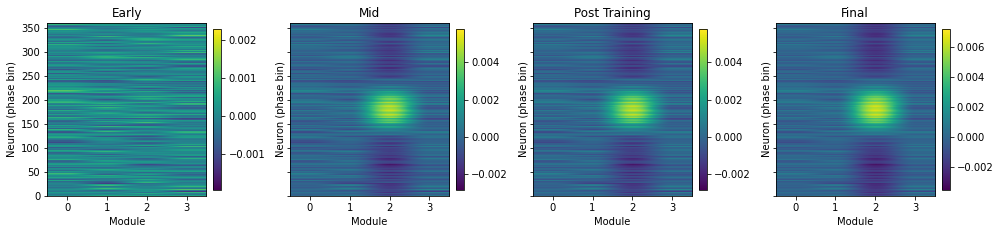

In [19]:
fig, axes = plt.subplots(1, len(snap_idxs), figsize=(14, 3.5), sharey=True)
for ax, idx, label in zip(axes, snap_idxs, snap_labels):
    im = ax.imshow(weight_snapshots[idx], aspect="auto", origin="lower")
    ax.set_title(label)
    ax.set_xlabel("Module")
    ax.set_ylabel("Neuron (phase bin)")
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

fig.suptitle("")
fig.tight_layout()
fig.savefig(OUTPUT_DIR / "fig4_landmark_weights.png", dpi=200)
plt.show()
plt.close(fig)

#### 6. Plot Weight Profiles

In [20]:
norm_weights = (weights - weights.min(axis=0)) / (
    weights.max(axis=0) - weights.min(axis=0) + 1e-12
)

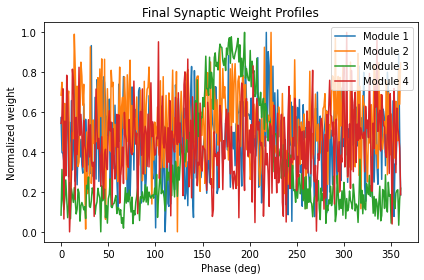

In [21]:
fig, ax = plt.subplots(figsize=(6, 4))
theta = np.linspace(0, 360, norm_weights.shape[0])
for mod in range(norm_weights.shape[1]):
    ax.plot(theta, norm_weights[:, mod], label=f"Module {mod + 1}")

ax.set_xlabel("Phase (deg)")
ax.set_ylabel("Normalized weight")
ax.set_title("Final Synaptic Weight Profiles")
ax.legend()
fig.tight_layout()
fig.savefig(OUTPUT_DIR / "fig4_weight_profiles.png", dpi=200)
plt.show()
plt.close(fig)

#### 7. Define the Continuous Attractor Network (CAN)

In [3]:
N_CAN_NEURONS = 364

TAU = 40 / 1000 # Synaptic time constant for CAN neurons

In [4]:
# Preferred phase for each CAN neuron
x_prefs = (np.arange(1, N_CAN_NEURONS + 1) / N_CAN_NEURONS).reshape(-1, 1)

# Global excitatory input
FF_global = 0.0 * np.ones(N_CAN_NEURONS)

##### 5.1. Define the "Mexican-hat" Kernel

In [5]:
# Mexican-hat kernel params
A_ext = 1.75
s_ext = 0.055 / 100   # narrower excitation (bigger s)
A_inh = 0.8
s_inh = 0.02 / 100   # broader inhibition (smaller s)
A_ginh = 0.5       # tune 0.1–0.5
s_ginh = 0.001/100   # extremely broad

In [6]:
# Make the Mexican-hat kernel
N = N_CAN_NEURONS

d = np.minimum(np.arange(N), N - np.arange(N)).astype(float)

mex_hat = (
      A_ext  * np.exp(-s_ext * d**2) 
    - A_inh  * np.exp(-s_inh * d**2)
    - A_ginh * np.exp(-s_ginh * d**2)
)

#mex_hat = mex_hat - mex_hat.mean()
#mex_hat = mex_hat - 0.001  # discourage multi-bumps

mex_hat = mex_hat / (np.sum(np.abs(mex_hat)) + 1e-12)  # prevents huge g

mex_hat *= 6.875

In [7]:
sym_err = np.max(np.abs(mex_hat - np.roll(mex_hat[::-1], 1)))
print("mex_hat circular-even symmetry maxabs:", sym_err)
print("mex_hat[0]:", mex_hat[0])
print("mex_hat[N//4]:", mex_hat[N_CAN_NEURONS//4])
print("mex_hat[N//2]:", mex_hat[N_CAN_NEURONS//2])
print("sum:", mex_hat.sum(), "max/min:", mex_hat.max(), mex_hat.min())

mex_hat circular-even symmetry maxabs: 0.0
mex_hat[0]: 0.01909541182716235
mex_hat[N//4]: -0.025229056021639405
mex_hat[N//2]: -0.0152796404136848
sum: -5.589881342916878 max/min: 0.01909541182716235 -0.027927688015399445


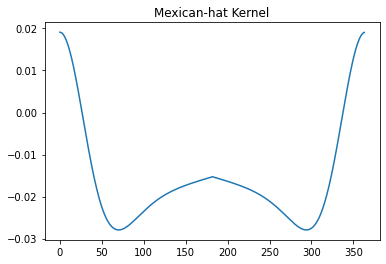

In [8]:
plt.title("Mexican-hat Kernel")
plt.plot(np.arange(N_CAN_NEURONS), mex_hat)
plt.show()

##### 5.2. Define the synaptic weights

In [9]:
W_RR = np.zeros((N_CAN_NEURONS, N_CAN_NEURONS))
W_LL = np.zeros((N_CAN_NEURONS, N_CAN_NEURONS))
W_RL = np.zeros((N_CAN_NEURONS, N_CAN_NEURONS))
W_LR = np.zeros((N_CAN_NEURONS, N_CAN_NEURONS))

bias = 5
for i in range(N_CAN_NEURONS):
    W_RR[i, :] = np.roll(mex_hat, i - bias)     # R bias backward
    W_LL[i, :] = np.roll(mex_hat, i + bias)     # L bias forward
    W_RL[i, :] = np.roll(mex_hat, i)            # No bias
    W_LR[i, :] = np.roll(mex_hat, i)            # No bias

#### 6. Initialize the CAN

Run a 10 second interval to "warm-up" the activity so that a bump forms in each ring (L and R).

In [10]:
# Define the time
dt = 1 / 2000
T = 10 # Simulate for 10
N_t = int(10 / dt) # Number of timesteps

In [11]:
# Define the external velocity stimuli
v_base = 0.0 # Zero base drive
weber_frac = 0.01
v_noise = weber_frac * np.random.randn()
v = (v_base + v_noise) * np.ones(N_t)

In [12]:
# Define an external anchoring bump
# (This helps the bump form at a consistent phase)
center = 0
gain = 1
std = 30

idx = np.arange(N_CAN_NEURONS)
d = np.minimum((idx - center) % N_CAN_NEURONS, (center - idx) % N_CAN_NEURONS)
landmark_half = gain * np.exp(-(d**2) / (2 * std**2))

landmark_bump = np.concatenate([landmark_half, landmark_half])

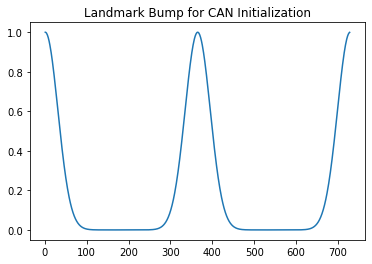

In [13]:
plt.title("Landmark Bump for CAN Initialization")
plt.plot(np.arange(1, 2*N_CAN_NEURONS + 1), landmark_bump)
plt.show()

In [14]:
# Create a vector to store CAN neuron activations over time
activations = np.zeros((2*N_CAN_NEURONS, N_t))

In [15]:
# Simulate
for t in range(1, N_t):
    
    # Left attractor stimuli
    v_l = 1 - 0.05 * v[t]
    g_ll = W_LL @ activations[:N_CAN_NEURONS, t-1]
    g_lr = W_LR @ activations[N_CAN_NEURONS:, t-1]
    g_l = v_l * ((g_ll + g_lr) + FF_global)

    # Right attractor stimuli
    v_r = 1 + 0.05 * v[t]
    g_rr = W_RR @ activations[N_CAN_NEURONS:, t-1]
    g_rl = W_RL @ activations[:N_CAN_NEURONS, t-1]
    g_r = v_r * ((g_rr + g_rl) + FF_global)

    # Add global competition (This supresses extra bumps)
    kappa = 0.0
    g_l -= kappa * activations[:N_CAN_NEURONS, t-1].sum()
    g_r -= kappa * activations[N_CAN_NEURONS:, t-1].sum()    

    # Combine the left and right stimuli
    g = np.concatenate([g_l, g_r])

    # Add the anchoring bump
    g += landmark_bump

    # Apply the nonlinearity
    theta = 0.0
    alpha = 1.0
    f = alpha * np.maximum(g - theta, 0.0)

    # Apply a low-pass filter update
    activations[:, t] = activations[:, t-1] + (f - activations[:, t-1]) * dt / TAU


In [16]:
# The last activation is the initial state
initial_activations = activations[:, -1]

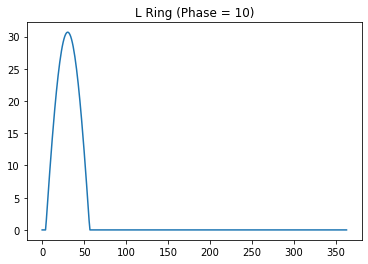

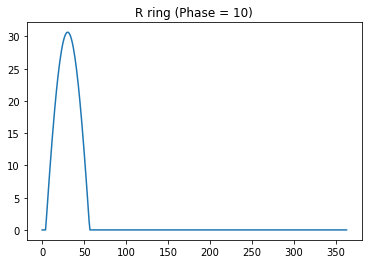

In [17]:
# Set the phase
L = initial_activations[:N_CAN_NEURONS]
R = initial_activations[N_CAN_NEURONS:]

L = np.roll(L, -np.argmax(L) + 30)
R = np.roll(R, -np.argmax(R) + 30)

plt.figure(); plt.plot(L); plt.title(f"L Ring (Phase = 10)"); plt.show()
plt.figure(); plt.plot(R); plt.title("R ring (Phase = 10)"); plt.show()

#### 8. CAN Simulation Settings

In [18]:
# Start the bump with the initial phase offset before the landmark timing onsets; 
# this keeps the first landmark at 60 from immediately triggering as soon as the simulation begins.
initial_phase = 30
start_idx = int(initial_phase / 360 * N_CAN_NEURONS)

# Stop once the bump has traversed a full 360° sweep of the ring, matching
# the target phase interval used in the publication analyses.
end_phase = 300
target_idx = int(end_phase / 360 * N_CAN_NEURONS)

# Landmark locations
centers_deg = np.array([45, 135, 225, 315], dtype=float)
centers_idx = (centers_deg / 360.0 * N_CAN_NEURONS).astype(int)

# Landmark dynamics
landmark_trigger_window = 12
landmark_onset = 0
landmark_tau = 250
landmark_max = 1.0

# Velocity scaling term
beta_vel = 0.8

# Velocity (without landmark input)
wolm_speed = 0.35

# Velocity (with landmark input)
wlm_speed = 0.35

# Noise strength
wm_values = (0.08, 0.05, 0.02)

# Simulate 60 secs
T = 60

# Time resolution
dt = 1 / 2000

# Number of timesteps
N_t = int(T / dt)

# Number of trials
num_sims = 50


In [19]:
# Shift the initial neuron activations so that the peak starts at the right phase
L = initial_activations[:N_CAN_NEURONS]
R = initial_activations[N_CAN_NEURONS:]

L = np.roll(L, -np.argmax(L) + start_idx)
R = L.copy()

initial_activations = np.concatenate([L, R])

In [20]:
# Compute the "unwrapped" centers
centers_unwrapped = []
for c in centers_idx:
    cu = c
    if cu < start_idx:
        cu += N_CAN_NEURONS
    centers_unwrapped.append(cu)
centers_unwrapped = np.array(centers_unwrapped)

#### 9. Run CAN Simulation with Landmarks

In [21]:
# Compute the peak phase by projecting the neuron activations onto the unit circle
def decode_phase_continuous(z: np.ndarray) -> float:
    N = z.size
    angles = 2*np.pi*np.arange(N)/N
    x = np.sum(z * np.cos(angles))
    y = np.sum(z * np.sin(angles))
    ang = np.arctan2(y, x)
    return (N * (ang % (2*np.pi)) / (2*np.pi))

In [22]:
plot = False

wlm_example_traj = None
wlm_example_unwrapped = None
wlm_variability_stats = []
wlm_times = {}

for wm in wm_values:

    wlm_traj_lens = []

    print()
    print(f"=== WM {wm}")

    for trial in range(num_sims):

        if trial % (num_sims // 4) == 0:
            print(f'  Trial {trial} / {num_sims}')

        # Construct velocity vector
        v = wlm_speed * (1.0 + wm * np.random.randn(N_t))
        v = np.clip(v, 0.0, None)

        # Initialize CAN state
        phase = [float(start_idx)]
        unwrapped = [float(start_idx)]
        activations = np.zeros((2 * N_CAN_NEURONS, N_t))
        activations[:, 0] = initial_activations
        lm_onset_times = []
        lm_peak_delays = []

        t = 0
        while unwrapped[-1] < target_idx and t < N_t - 1:
            t += 1

            # Left attractor internal stimuli
            v_l = np.clip(1 - beta_vel * v[t], 0.0, 2.0)
            g_ll = W_LL @ activations[:N_CAN_NEURONS, t-1]
            g_lr = W_LR @ activations[N_CAN_NEURONS:, t-1]
            g_l = v_l * ((g_ll + g_lr) + FF_global)

            # Right attractor internal stimuli
            v_r = np.clip(1 + beta_vel * v[t], 0.0, 2.0)
            g_rr = W_RR @ activations[N_CAN_NEURONS:, t-1]
            g_rl = W_RL @ activations[:N_CAN_NEURONS, t-1]
            g_r = v_r * ((g_rr + g_rl) + FF_global) 

            # External stimuli from landmarks
            landmark_input = np.zeros(N_CAN_NEURONS)
            next_lm = len(lm_onset_times)
            if next_lm < len(centers_unwrapped):
                c = centers_unwrapped[next_lm]
                dist_to_c = c - unwrapped[-1]

                # trigger only when approaching from below and inside window
                if 0.0 <= dist_to_c <= landmark_trigger_window:
                    recent = np.diff(unwrapped[-201:]) if len(unwrapped) > 201 else np.diff(unwrapped)
                    recent = recent[recent > 0]
                    step_est = float(np.median(recent)) if recent.size >= 10 else 1e-3

                    delay = int(np.clip(dist_to_c / step_est, 0, 5000))
                    lm_onset_times.append(t)
                    lm_peak_delays.append(delay)

            for idx, onset in enumerate(lm_onset_times):
                # Landmark signal delay
                dt_since = t - onset
                if dt_since < landmark_onset:
                    continue
                # Clip old landmark signals
                peak_delay = lm_peak_delays[idx]
                amp = landmark_max * np.exp(-((dt_since - peak_delay) ** 2) / (2 * landmark_tau**2))
                if amp < 1e-3:
                    continue
                # Compute landmark signal (even + odd component)
                center_wrapped = centers_unwrapped[idx] % N_CAN_NEURONS

                # signed shortest distance from each neuron to center in [-N/2, N/2)
                d = (np.arange(N_CAN_NEURONS) - center_wrapped + N_CAN_NEURONS/2) % N_CAN_NEURONS - N_CAN_NEURONS/2
                sigma = 5.0

                # even (Gaussian)
                even = np.exp(-(d**2) / (2 * sigma**2))
                even -= even.mean()
                even /= (even.max() + 1e-12)

                # odd (derivative of Gaussian): points toward the center
                odd = -(d / (sigma**2)) * np.exp(-(d**2) / (2 * sigma**2))
                odd /= (np.max(np.abs(odd)) + 1e-12)

                # sign based on whether bump is before(+) or after(-) the landmark
                # err > 0 means bump is behind the landmark -> push it forward toward center
                err = centers_unwrapped[idx] - unwrapped[-1]
                err = np.clip(err, -landmark_trigger_window, landmark_trigger_window)
                err_norm = err / landmark_trigger_window
                LM_ODD_GAIN = 1.0
                signal = even + LM_ODD_GAIN * err_norm * odd

                signal -= signal.mean()
                signal /= (np.max(np.abs(signal)) + 1e-12)
                landmark_input += amp * signal

            g_l += landmark_input
            g_r -= landmark_input

            # Combine left and right stimuli
            g = np.concatenate([g_l, g_r])

            # Apply the non-linearity
            f_max = 4.0
            k = 3.0
            f = f_max * np.tanh(np.maximum(g, 0.0) / k)

            # Apply the update
            activations[:, t] = activations[:, t-1] + (f - activations[:, t-1]) * dt / TAU

            # Select the current phase
            z = activations[:N_CAN_NEURONS, t]
            prev = phase[-1]
            peak = decode_phase_continuous(z)
            update = (peak - prev + N_CAN_NEURONS/2) % N_CAN_NEURONS - N_CAN_NEURONS/2

            phase.append(peak)
            unwrapped.append(unwrapped[-1] + update)

            if plot and t % 5000 == 0:
                print("t", t,
                "peak", z.max(),
                "sumL", activations[:N_CAN_NEURONS, t].sum(),
                "gL max/min", g_l.max(), g_l.min(),
                "gR max/min", g_r.max(), g_r.min()
                )
                print("LM max/min:", 
                    landmark_input.max(), 
                    landmark_input.min(), 
                    "num_seen:", len(lm_onset_times)
                )
                plt.clf() 
                plt.plot(np.arange(N_CAN_NEURONS), z) 
                plt.xlabel("Neurons") 
                plt.ylabel("Activations") 
                plt.pause(0.25)
        
        # Save the first trajectory as an example
        if wlm_example_traj is None:
            wlm_example_traj = phase.copy()

        # Save the first unwrapped trajectory as an example
        if wlm_example_unwrapped is None:
            wlm_example_unwrapped = unwrapped.copy()
        
        # Save the trajectory length
        wlm_traj_lens.append(len(phase) - 1)
    
    # Save variability stats
    times = np.array(wlm_traj_lens) * dt
    wlm_times[wm] = times
    wlm_variability_stats.append((wm, float(times.mean()), float(times.std())))
    


=== WM 0.08
  Trial 0 / 50
  Trial 12 / 50
  Trial 24 / 50
  Trial 36 / 50
  Trial 48 / 50

=== WM 0.05
  Trial 0 / 50
  Trial 12 / 50
  Trial 24 / 50
  Trial 36 / 50
  Trial 48 / 50

=== WM 0.02
  Trial 0 / 50
  Trial 12 / 50
  Trial 24 / 50
  Trial 36 / 50
  Trial 48 / 50


In [23]:
wlm_variability_stats

[(0.08, 11.935880000000003, 0.006487341520222425),
 (0.05, 11.94119, 0.00376814277861135),
 (0.02, 11.9441, 0.0018165902124585992)]

#### 10. Run CAN Simulation without Landmarks

In [24]:
# Compute wrapped updates
def wrapped_delta(new, old, N):
    return (new - old + N/2) % N - N/2

In [25]:
plot = False

wolm_example_traj = None
wolm_example_unwrapped = None
wolm_variability_stats = []
wolm_times = {}

for wm in wm_values:

    wolm_traj_lens = []

    print()
    print(f"=== WM {wm}")

    for trial in range(num_sims):

        if trial % (num_sims // 4) == 0:
            print(f"Trial {trial} / {num_sims}")

        # Construct velocity vector
        v = wolm_speed * (1.0 + wm * np.random.randn(N_t))
        v = np.clip(v, 0.0, None)
        if trial == 0:
            print("v mean/std:", v.mean(), v.std(), "min/max:", v.min(), v.max())

        # Initialize CAN state
        phase = [start_idx]
        unwrapped = [start_idx]
        activations = np.zeros((2 * N_CAN_NEURONS, N_t))
        activations[:, 0] = initial_activations

        t = 0
        while unwrapped[-1] < target_idx and t < N_t - 1:
            t += 1

            # Left attractor internal stimuli
            v_l = np.clip(1 - beta_vel * v[t], 0.0, 2.0)
            g_ll = W_LL @ activations[:N_CAN_NEURONS, t-1]
            g_lr = W_LR @ activations[N_CAN_NEURONS:, t-1]
            g_l = v_l * ((g_ll + g_lr) + FF_global)

            # Right attractor internal stimuli
            v_r = np.clip(1 + beta_vel * v[t], 0.0, 2.0)
            g_rr = W_RR @ activations[N_CAN_NEURONS:, t-1]
            g_rl = W_RL @ activations[:N_CAN_NEURONS, t-1]
            g_r = v_r * ((g_rr + g_rl) + FF_global)   

            # Combine left and right stimuli
            g = np.concatenate([g_l, g_r])

            # Apply the non-linearity
            f_max = 4.0
            k = 3.0
            f = f_max * np.tanh(np.maximum(g, 0.0) / k)

            # Apply the update
            activations[:, t] = activations[:, t-1] + (f - activations[:, t-1]) * dt / TAU

            # Get the peak
            z = activations[:N_CAN_NEURONS, t]
            peak = decode_phase_continuous(z)

            # Store phase and phase delta
            update = wrapped_delta(peak, phase[-1], N_CAN_NEURONS)
            phase.append(peak)
            unwrapped.append(unwrapped[-1] + update)
            
            if plot and t % 5000 == 0:
                print("t", t,
                "peak", z.max(),
                "sumL", activations[:N_CAN_NEURONS, t].sum(),
                "gL max/min", g_l.max(), g_l.min(),
                "gR max/min", g_r.max(), g_r.min()
                )
                plt.clf() 
                plt.plot(np.arange(N_CAN_NEURONS), z) 
                plt.xlabel("Neurons") 
                plt.ylabel("Activations") 
                plt.pause(0.25)

        # Save the first phase trajectory as an example
        if wolm_example_traj is None:
            wolm_example_traj = phase
        
        # Save the first unwrapped trajectory as an example
        if wolm_example_unwrapped is None:
            wolm_example_unwrapped = unwrapped
        
        # Save the trajectory length
        wolm_traj_lens.append(len(phase) - 1)
    
    # Save variability stats
    times = np.array(wolm_traj_lens) * dt
    wolm_times[wm] = times
    wolm_variability_stats.append((wm, float(times.mean()), float(times.std())))


=== WM 0.08
Trial 0 / 50
v mean/std: 0.3498192492338405 0.02796845476246493 min/max: 0.22706138566567996 0.4684188486025962
Trial 12 / 50
Trial 24 / 50
Trial 36 / 50
Trial 48 / 50

=== WM 0.05
Trial 0 / 50
v mean/std: 0.34995758125868476 0.01748949390432274 min/max: 0.27582948703835497 0.43123762799896515
Trial 12 / 50
Trial 24 / 50
Trial 36 / 50
Trial 48 / 50

=== WM 0.02
Trial 0 / 50
v mean/std: 0.35001242356168555 0.006986041053891811 min/max: 0.31464136819259475 0.37853405457338973
Trial 12 / 50
Trial 24 / 50
Trial 36 / 50
Trial 48 / 50


In [26]:
wolm_variability_stats

[(0.08, 11.718870000000003, 0.006740037091885982),
 (0.05, 11.72422, 0.0042345719972626),
 (0.02, 11.72656, 0.0016206171663906061)]

#### 11. Plot the Example Trajectories

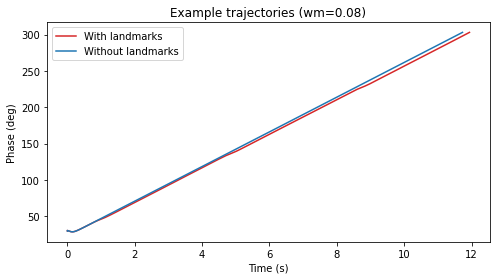

In [27]:
fig, ax = plt.subplots(figsize=(7, 4))
t_wint, y_wint = dt * np.arange(len(wlm_example_traj)), np.array(wlm_example_traj)
t_wolm, y_wolm = dt * np.arange(len(wolm_example_traj)), np.array(wolm_example_traj)
ax.plot(t_wint, y_wint, label="With landmarks", color="#d62728")
ax.plot(t_wolm, y_wolm, label="Without landmarks", color="#1f77b4")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Phase (deg)")
ax.set_title(f"Example trajectories (wm={wm_values[0]})")
ax.legend()
fig.tight_layout()

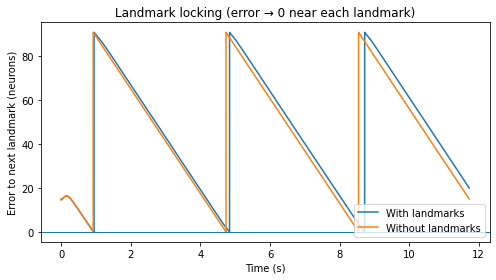

In [28]:
def wrap_signed(x, N):
    return (x + N/2) % N - N/2

def phase_error_trace(unwrapped, centers_unwrapped):
    # for each time, pick the next landmark (or nearest) and compute signed error
    unwrapped = np.asarray(unwrapped)
    errs = np.zeros_like(unwrapped)

    for i, u in enumerate(unwrapped):
        # next landmark index (first center >= u), else last
        k = np.searchsorted(centers_unwrapped, u, side="left")
        k = min(k, len(centers_unwrapped)-1)
        c = centers_unwrapped[k]
        errs[i] = c - u  # signed (positive means "behind" the landmark)
    return errs

N_t = min(len(wlm_example_unwrapped), len(wolm_example_unwrapped))
t = dt * np.arange(N_t)
err_wlm  = phase_error_trace(wlm_example_unwrapped[:N_t], centers_unwrapped)
err_wolm = phase_error_trace(wolm_example_unwrapped[:N_t], centers_unwrapped)

plt.figure(figsize=(7,4))
plt.plot(t, err_wlm, label="With landmarks")
plt.plot(t, err_wolm, label="Without landmarks")
for c in centers_unwrapped:
    plt.axhline(0, linewidth=1)
plt.xlabel("Time (s)")
plt.ylabel("Error to next landmark (neurons)")
plt.title("Landmark locking (error → 0 near each landmark)")
plt.legend()
plt.tight_layout()
plt.show()


#### 12. Plot the Variability Statistics

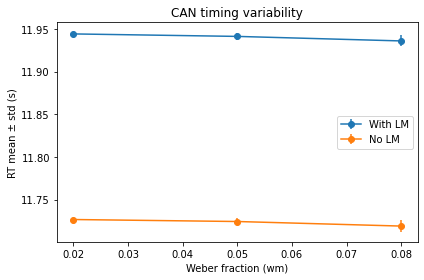

In [29]:
fig, ax = plt.subplots(figsize=(6, 4))

wlm_means = [mean for _, mean, _ in wlm_variability_stats]
wlm_stds = [std for _, _, std in wlm_variability_stats]

wolm_means = [mean for _, mean, _ in wolm_variability_stats]
wolm_stds = [std for _, _, std in wolm_variability_stats]

ax.errorbar(wm_values, wlm_means, yerr=wlm_stds, fmt="o-", label="With LM")
ax.errorbar(wm_values, wolm_means, yerr=wolm_stds, fmt="o-", label="No LM")
ax.set_xlabel("Weber fraction (wm)")
ax.set_ylabel("RT mean ± std (s)")
ax.set_title("CAN timing variability")
ax.legend()
fig.tight_layout()
fig.savefig(OUTPUT_DIR / "means_and_variabillity.png", dpi=200)
plt.show()
plt.close(fig)

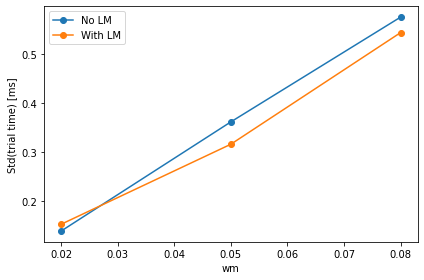

In [31]:
scale = 1000  # seconds -> milliseconds

plt.figure(figsize=(6,4))
plt.plot(wm_values, np.array(wolm_stds)*scale / np.array(wolm_means), marker='o', label="No LM")
plt.plot(wm_values, np.array(wlm_stds)*scale  / np.array(wlm_means), marker='o', label="With LM")
plt.xlabel("wm")
plt.ylabel("Std(trial time) [ms]")
plt.legend()
plt.tight_layout()
#plt.savefig(OUTPUT_DIR / "variabillity.png", dpi=200)
plt.show()